# Pytorch-shap-预训练图像分类可解释性分析

对Pytorch模型库中的ImageNet预训练图像分类模型进行可解释性分析。可视化指定预测类别的shap值热力图。

## 导入工具包

In [8]:
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from network import ShuffleNetV2_Plus
from torchvision import transforms
import shap
from train_come15k import copy_state_dict

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入预训练图像分类模型

In [6]:
## 载入ImageNet1k预训练图像分类模型
# init model choose ['Small','Medium','Large']
model_size = 'Medium'
architecture = [0, 0, 3, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 3, 2]
class_names = ['covering', 'device', 'domestic_animal', 'mater', 'person', 'plant', 'structure', 'vertebrate']
model = ShuffleNetV2_Plus(architecture=architecture, n_class=class_names.__len__(), model_size=model_size)
pre_train_model_weight_dic = {
    'Small': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Small.pth.tar',
    'Medium': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Medium.pth.tar',
    'Large': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Large.pth.tar'
    }
# 载入预训练
pre_train_weight = torch.load(pre_train_model_weight_dic[model_size])
# 去掉分类层
new_dict = copy_state_dict(pre_train_weight)
keys = []
for k, v in new_dict.items():
    if k.startswith('classifier'):  # 将‘’开头的key过滤掉，这里是要去除的层的key
        continue
    keys.append(k)
new_dict = {k: new_dict[k] for k in keys}
state_dict = new_dict
model.load_state_dict(state_dict, strict=False)

model size is  Medium


_IncompatibleKeys(missing_keys=['classifier.0.weight'], unexpected_keys=[])

In [7]:
## 载入预训练图像分类模型
# init model ['Small','Medium','Large']
model_size = 'Medium'
architecture = [0, 0, 3, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 3, 2]
class_names = ['covering', 'device', 'domestic_animal', 'mater', 'person', 'plant', 'structure', 'vertebrate']
model = ShuffleNetV2_Plus(architecture=architecture, n_class=class_names.__len__(), model_size=model_size)
pre_retrain_model_weight_dic = {
    'Small': '/',
    'Medium': '/',
    'Large': '/'
    }
pre_train_weight = torch.load(pre_train_model_weight_dic[model_size])
model.load_state_dict(pre_train_weight, strict=True)

model size is  Medium


RuntimeError: Error(s) in loading state_dict for ShuffleNetV2_Plus:
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([1000, 1280]) from checkpoint, the shape in current model is torch.Size([8, 1280]).

## 载入一张测试图像，整理维度

In [26]:
# img_path = 'test_img/test_草莓.jpg'

img_path = 'test_img/cat_dog.jpg'

In [27]:
img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [28]:
X.shape

torch.Size([1, 1560, 2340, 3])

## 预处理

In [29]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 构建模型预测函数

In [30]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [31]:
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [32]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [33]:
out.shape

torch.Size([1, 1000])

In [34]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [232]: ['Border_collie']


## 设置shap可解释性分析算法

In [35]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [36]:
input_img.shape

torch.Size([1, 224, 336, 3])

In [37]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [38]:
# 281：虎斑猫 tabby
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[281])

Partition explainer: 2it [00:10, 10.80s/it]                                     


In [39]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [40]:
# 原图
shap_values.data.shape

(224, 336, 3)

In [41]:
# shap值热力图
shap_values.values[0].shape

(224, 336, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


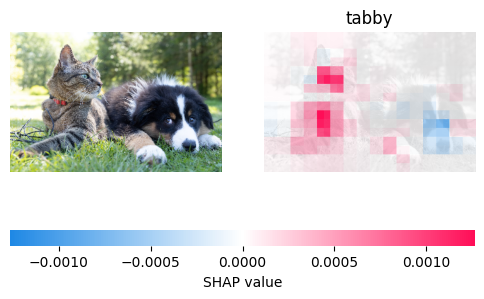

In [42]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [43]:
# 232 边牧犬 border collie
# 281：虎斑猫 tabby
# 852 网球 tennis ball
# 288 豹子 leopard
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[232, 281, 852, 288])

Partition explainer: 2it [00:11, 11.45s/it]                                     


In [44]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [45]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(4, 224, 336, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


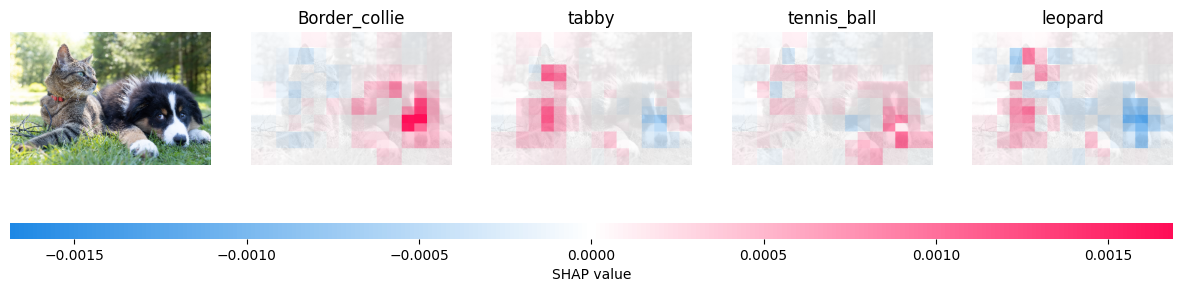

In [46]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前k个预测类别

In [47]:
topk = 5

In [48]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

Partition explainer: 2it [00:11, 11.48s/it]                                     


In [49]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(1, 224, 336, 3, 5)

In [50]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [51]:
# 各个类别的shap值热力图
len(shap_values.values)

5

In [52]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

(224, 336, 3)

In [55]:
# 第一个类别，shap值热力图
shap_values.values[1].shape

(224, 336, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


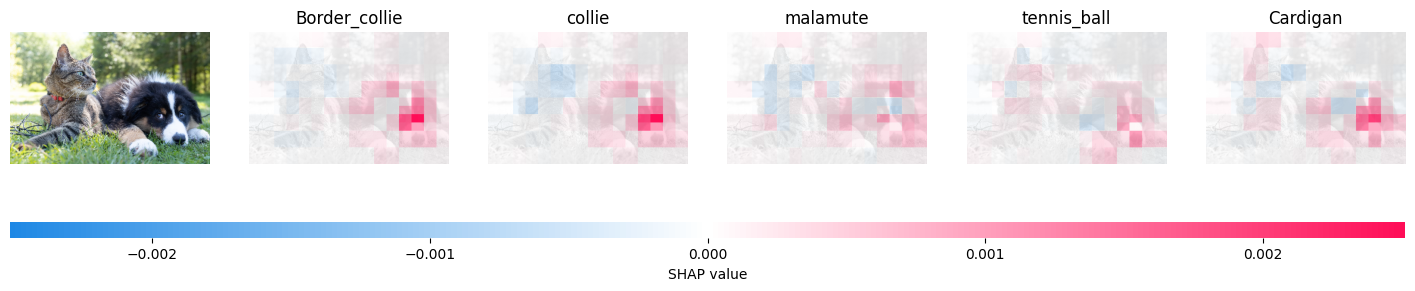

In [54]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )